# **Import the Necessary Libraries**

In [1]:
import numpy as np
import pandas as pd
from itertools import combinations
from collections import defaultdict
import ast
from tqdm import tqdm
import matplotlib.pyplot as plt

# **Read The CSV File With The Coordinates & Speeds**

In [2]:
"""

Input: path to the excel file containing vehicle data based on SUMO simulation
Output: Dictionary with vehicle IDs as keys and their coordinates, speeds, and their street locations as values
Functionality:
                - Reads the excel file containing vehicle data.
                - Parses the coordinates and speeds from the 'coord' and 'spd' columns.
                - Groups the data by vehicle ID, storing the coordinates and speeds as tuples in a list.

"""

def get_vehicle_data(path, scenario='highway'):

    data = pd.read_excel(path) # Read the excel file containing vehicle data
    vehicle_data = {} # Initialize an empty dictionary to store vehicle data

    coordinates = data['coord'].apply(ast.literal_eval).tolist() # Convert string representation of lists to actual lists
    speeds = data['spd'].tolist() # Extract speeds from the dataframe
    street = data['edge'].tolist() # Extract street information from the dataframe

    for i in range(len(data)):
        vehicle_id = data['vehid'][i] # Extract vehicle ID from the dataframe
        if vehicle_id not in vehicle_data: # If the vehicle ID is not already in the dictionary, initialize it
            vehicle_data[vehicle_id] = {
                'coord, speed': []
            }

        vehicle_data[vehicle_id]['coord, speed'].append((coordinates[i], speeds[i])) # Append the coordinates and speed as a tuple to the list for that vehicle ID
        
        if scenario != 'highway': # If the scenario is not highway, store the street information
            vehicle_data[vehicle_id]['edge'] = street[i] # Store the street information for that vehicle ID

    return vehicle_data

####################################################################################################################################################################################

# Test the code here with the provided paths

# Highway data paths

vehicle_data_245 = get_vehicle_data('C:/Users/Vaideeswaran/Documents/ACS Project/traces/3km_highway_70kmph_245vh/output.xlsx')
vehicle_data_123 = get_vehicle_data('C:/Users/Vaideeswaran/Documents/ACS Project/traces/3km_highway_140kmph_123vh/output.xlsx')

# Urban data paths

# vehicle_data_100 = get_vehicle_data('C:/Users/Vaideeswaran/Documents/ACS Project/traces/urban_60kmph_100vh/output.xlsx', scenario = 'Urban')
# vehicle_data_200 = get_vehicle_data('C:/Users/Vaideeswaran/Documents/ACS Project/traces/urban_60kmph_200vh/output.xlsx', scenario = 'Urban')
# vehicle_data_300 = get_vehicle_data('C:/Users/Vaideeswaran/Documents/ACS Project/traces/urban_60kmph_300vh/output.xlsx', scenario = 'Urban')

## **Velocity Extraction**

In [3]:
"""

Input: Dictionary with vehicle IDs as keys and their coordinates, speeds, and street locations as values
Output: Modified dictionary with an additional key 'velocity' for each vehicle ID
Functionality:
                - Calculates the velocity of each vehicle based on its coordinates and speed.
                - The velocity is represented as a 2D vector, where the direction is determined by the displacement between consecutive coordinates.

"""

def get_velocity(vehicle_data, scenario='highway'):

    for vehicle_id, data in vehicle_data.items(): # Iterate through each vehicle's data
        vehicle_data[vehicle_id]['velocity'] = np.zeros((len(data['coord, speed']), 2)) # Initialize a numpy array to store velocity vectors
        vehicle_data[vehicle_id]['predicted'] = np.zeros((len(data['coord, speed']), 2)) # Initialize a numpy array to store predicted velocities
        for i in range(1, len(data['coord, speed'])):
            displacement = np.array(data['coord, speed'][i][0]) - np.array(data['coord, speed'][i - 1][0]) # Calculate the displacement between consecutive coordinates
            if np.linalg.norm(displacement) > 0: # Check if the displacement is non-zero to avoid division by zero
                unit_vector = displacement / np.linalg.norm(displacement) # Normalize the displacement to get the unit vector
                vehicle_data[vehicle_id]['velocity'][i] = data['coord, speed'][i][1] * unit_vector # Scale the unit vector by the speed to get the velocity vector

                if scenario == 'highway':
                    predicted_velocity = displacement * 36
                else:
                    predicted_velocity = displacement * 3.6

                vehicle_data[vehicle_id]['predicted'][i] = predicted_velocity # Store the predicted velocity in the dictionary

    return vehicle_data

####################################################################################################################################################################################

# Test the code here with the provided vehicle data dictionaries

# Highway data

vehicle_data_245 = get_velocity(vehicle_data_245)
vehicle_data_123 = get_velocity(vehicle_data_123)

# Urban data

# vehicle_data_100 = get_velocity(vehicle_data_100, scenario = 'Urban')
# vehicle_data_200 = get_velocity(vehicle_data_200, scenario = 'Urban')
# vehicle_data_300 = get_velocity(vehicle_data_300, scenario = 'Urban')

# **Form All The Valid Pairs**

In [4]:
"""

Input: path to the excel file containing vehicle data based on SUMO simulation, dictionary containing vehicle data, and a threshold distance
Output: List of valid vehicle pairs at each timestamp where the distance between them is less than the threshold
Functionality:
                - Reads the excel file containing vehicle data.
                - For each timestamp, collects active vehicles (vehicles with data at that timestamp).
                - Compares all active vehicle pairs and checks if their distance is less than the threshold.
                - Returns a list of valid pairs (timestamp, vehicle1 ID, vehicle2 ID).

"""

def valid_pairs(path, vehicle_data, threshold, vel_threshold = 1):

    data = pd.read_excel(path) # Read the excel file containing vehicle data
    time_instants = [] # Initialize an empty list to store the number of time instants for each vehicle

    for i in tqdm(range(len(vehicle_data))): # Iterate through each vehicle's data
        time_instants.append(len(vehicle_data[i]['coord, speed'])) # Append the length of the 'coord, speed' list for each vehicle to the time_instants list

    max_time_instants = max(time_instants) # Get the maximum number of time instants across all vehicles
    print(np.sum(time_instants) == len(data)) # Check if the total number of time instants matches the length of the data

    all_valid_pairs = [] # Initialize an empty list to store all valid pairs of vehicles

    for t in tqdm(range(max_time_instants)): # Iterate through each timestamp
        active_vehicles = [] # Initialize an empty list to store active vehicles at this timestamp

        # Collect vehicles that have data at this timestamp
        for veh_id, vdata in vehicle_data.items():
            if t < len(vdata['coord, speed']):

                # Check if the predicted velocity exceeds the actual velocity by more than the threshold
                
                if np.linalg.norm(vdata['predicted'][t] - vdata['velocity'][t]) <= vel_threshold:
                    coord = vdata['coord, speed'][t][0]
                    active_vehicles.append((veh_id, coord))

        # Compare all active vehicle pairs at time t and check if their distance is less than the threshold
        for (veh1, coord1), (veh2, coord2) in combinations(active_vehicles, 2):
            if np.linalg.norm(np.array(coord1) - np.array(coord2)) < threshold:
                all_valid_pairs.append((t, veh1, veh2))

    print(np.shape(all_valid_pairs)) 

    return all_valid_pairs

####################################################################################################################################################################################

# Test the code here with the provided paths and vehicle data dictionaries

# Highway pairs

all_valid_pairs_245 = valid_pairs('C:/Users/Vaideeswaran/Documents/ACS Project/traces/3km_highway_70kmph_245vh/output.xlsx', vehicle_data_245, threshold = 1000)
all_valid_pairs_123 = valid_pairs('C:/Users/Vaideeswaran/Documents/ACS Project/traces/3km_highway_140kmph_123vh/output.xlsx', vehicle_data_123, threshold = 1000)

# Urban pairs

# all_valid_pairs_100 = valid_pairs('C:/Users/Vaideeswaran/Documents/ACS Project/traces/urban_60kmph_100vh/output.xlsx', vehicle_data_100, threshold = 500)
# all_valid_pairs_200 = valid_pairs('C:/Users/Vaideeswaran/Documents/ACS Project/traces/urban_60kmph_200vh/output.xlsx', vehicle_data_200, threshold = 500)
# all_valid_pairs_300 = valid_pairs('C:/Users/Vaideeswaran/Documents/ACS Project/traces/urban_60kmph_300vh/output.xlsx', vehicle_data_300, threshold = 500)

100%|██████████| 245/245 [00:00<?, ?it/s]


True


100%|██████████| 4018/4018 [02:29<00:00, 26.83it/s] 


(35740647, 3)


100%|██████████| 123/123 [00:00<00:00, 129071.65it/s]


True


100%|██████████| 1726/1726 [00:20<00:00, 82.67it/s] 

(4994375, 3)


# **Preparing the Information Vector**

In [5]:
"""

Input: Dictionary with the vehicular data, list of valid vehicle pairs, and a time window (default: 1 second)
Output: Information vector containing pairs of coordinates and their relative velocity, and a new state vector with updated coordinates and relative velocities. The street
        information is also included in the new state vector to judge between NLOS and LOS/NLOSv.
Functionality:
                - For each valid pair of vehicles, finds the next timestamp within the specified time window.
                - Computes the coordinates and velocities at both timestamps.
                - Constructs an information vector with pairs of coordinates and their relative velocity.
                - Constructs a new state vector with updated coordinates, relative velocities, and street information.

"""

def information(vehicle_data, all_valid_pairs, window = 1, scenario='highway'):

    pair_times = defaultdict(list) # Initialize a dictionary to store timestamps for each vehicle pair

    for t, veh1, veh2 in all_valid_pairs: # Iterate through all valid pairs
        pair_times[(veh1, veh2)].append(t)

    ################################################################################################################################################################################

    info_vector, new_state = [], []  # Initialize empty lists for information vector and new state

    for t, veh1, veh2 in tqdm(all_valid_pairs): # Iterate through each valid pair of vehicles
        times = pair_times[(veh1, veh2)]

        # Find matching t_prime where t_prime is the next timestamp within the specified time window
        matching_t_prime = None
        for t_prime in times:
            if t_prime > t and t_prime - t <= window: # Check if t_prime is within the time window
                matching_t_prime = t_prime
                break  # stop at first found

        if matching_t_prime is not None:

            # Get the coordinates and velocities at the present timestamp

            coord1 = vehicle_data[veh1]['coord, speed'][t][0]
            coord2 = vehicle_data[veh2]['coord, speed'][t][0]
            vel1 = vehicle_data[veh1]['velocity'][t]
            vel2 = vehicle_data[veh2]['velocity'][t]

            # Get the coordinates and velocities at the next timestamp

            coord1_prime = vehicle_data[veh1]['coord, speed'][matching_t_prime][0]
            coord2_prime = vehicle_data[veh2]['coord, speed'][matching_t_prime][0]
            if scenario != 'highway':
                street1_prime = vehicle_data[veh1]['edge']
                street2_prime = vehicle_data[veh2]['edge']
            vel1_prime = vehicle_data[veh1]['velocity'][matching_t_prime]
            vel2_prime = vehicle_data[veh2]['velocity'][matching_t_prime]

            ########################################################################################################################################################################

            info_vector.append((coord1, coord2, np.linalg.norm(vel1 - vel2))) # Append the pair of coordinates and their relative velocity to the information vector
            info_vector.append((coord2, coord1, np.linalg.norm(vel2 - vel1))) # Append the reverse pair as well for symmetry

            ########################################################################################################################################################################

            # Save the new state

            if scenario != 'highway':
                new_state.append((coord1_prime, coord2_prime, np.linalg.norm(vel1_prime - vel2_prime), street1_prime, street2_prime))
                new_state.append((coord2_prime, coord1_prime, np.linalg.norm(vel2_prime - vel1_prime), street2_prime, street1_prime)) # Append the reverse pair as well for symmetry
            else:
                new_state.append((coord1_prime, coord2_prime, np.linalg.norm(vel1_prime - vel2_prime)))
                new_state.append((coord2_prime, coord1_prime, np.linalg.norm(vel2_prime - vel1_prime)))

    ################################################################################################################################################################################

    return info_vector, new_state

####################################################################################################################################################################################

# Test the code here with the provided vehicle data dictionaries and valid pairs

# Highway data

info_vector_123, new_state_123 = information(vehicle_data_123, all_valid_pairs_123)
info_vector_245, new_state_245 = information(vehicle_data_245, all_valid_pairs_245)

print(len(info_vector_123), len(new_state_123)) # Print the lengths of the information vector and new state for vehicle data 123
print(len(info_vector_245), len(new_state_245)) # Print the lengths of the information vector and new state for vehicle data 245

# Urban data

# info_vector_100, new_state_100 = information(vehicle_data_100, all_valid_pairs_100, scenario = 'Urban')
# info_vector_200, new_state_200 = information(vehicle_data_200, all_valid_pairs_200, scenario = 'Urban')
# info_vector_300, new_state_300 = information(vehicle_data_300, all_valid_pairs_300, scenario = 'Urban')

# print(len(info_vector_100), len(new_state_100)) # Print the lengths of the information vector and new state for vehicle data 100
# print(len(info_vector_200), len(new_state_200)) # Print the lengths of the information vector and new state for vehicle data 200
# print(len(info_vector_300), len(new_state_300)) # Print the lengths of the information vector and new state for vehicle data 300

100%|██████████| 35740647/35740647 [18:30<00:00, 32172.96it/s] 


9931670 9931670
71201146 71201146


# **Obtain The Training Samples - Highway**

In [22]:
num_samples = 1500000 # Define the total number of training samples

# Perform the sampling (uniform sampling across the three traffic scenarios)

size = num_samples // 2 # Calculate the size for each traffic scenario

indices_123_train = np.random.choice(len(info_vector_123), size, replace = False)
indices_245_train = np.random.choice(len(info_vector_245), size, replace = False)

# Initialize empty lists to store the sampled information vectors and new states for each traffic scenario

sampled_info_vector_123, sampled_new_state_123 = [], []
sampled_info_vector_245, sampled_new_state_245 = [], []

####################################################################################################################################################################################

# Sample for the 123 vehicle scenario

for index in tqdm(indices_123_train):
    sampled_info_vector_123.append(info_vector_123[index])
    sampled_new_state_123.append(new_state_123[index])

# Sample for the 245 vehicle scenario

for index in tqdm(indices_245_train):
    sampled_info_vector_245.append(info_vector_245[index])
    sampled_new_state_245.append(new_state_245[index])

####################################################################################################################################################################################

# Final dataset

final_info_vector = sampled_info_vector_123 + sampled_info_vector_245 # Concatenate the sampled information vectors from all traffic scenarios
final_new_state = sampled_new_state_123 + sampled_new_state_245 # Concatenate the sampled new states from all traffic scenarios

print(len(final_info_vector)) # Print the total number of samples in the final information vector
print(len(final_new_state)) # Print the total number of samples in the final new state vector

####################################################################################################################################################################################

# Save the final dataset to a CSV file

final_df = pd.DataFrame({
    'info_vector': final_info_vector,
    'new_state': final_new_state
})
final_df.to_csv('C:/Users/Vaideeswaran/Documents/ACS Project/Learning Dataset/train_highway_dataset.csv', index = False) # Save the DataFrame to a CSV file without the index

100%|██████████| 750000/750000 [01:36<00:00, 7734.54it/s] 


1500000
1500000


# **Obtain The Training Samples - Urban**

In [6]:
num_samples = 1500000 # Define the total number of training samples

# Perform the sampling (uniform sampling across the three traffic scenarios)

size = num_samples // 3 # Calculate the size for each traffic scenario

indices_100_train = np.random.choice(len(info_vector_100), size, replace = False)
indices_200_train = np.random.choice(len(info_vector_200), size, replace = False)
indices_300_train = np.random.choice(len(info_vector_300), size, replace = False)

# Initialize empty lists to store the sampled information vectors and new states for each traffic scenario

sampled_info_vector_100, sampled_new_state_100 = [], []
sampled_info_vector_200, sampled_new_state_200 = [], []
sampled_info_vector_300, sampled_new_state_300 = [], []

####################################################################################################################################################################################

# Sample for the 100 vehicle scenario

for index in tqdm(indices_100_train):
    sampled_info_vector_100.append(info_vector_100[index])
    sampled_new_state_100.append(new_state_100[index])

# Sample for the 200 vehicle scenario

for index in tqdm(indices_200_train):
    sampled_info_vector_200.append(info_vector_200[index])
    sampled_new_state_200.append(new_state_200[index])

# Sample for the 300 vehicle scenario

for index in tqdm(indices_300_train):
    sampled_info_vector_300.append(info_vector_300[index])
    sampled_new_state_300.append(new_state_300[index])

####################################################################################################################################################################################

# Final dataset

final_info_vector = sampled_info_vector_100 + sampled_info_vector_200 + sampled_info_vector_300 # Concatenate the sampled information vectors from all traffic scenarios
final_new_state = sampled_new_state_100 + sampled_new_state_200 + sampled_new_state_300 # Concatenate the sampled new states from all traffic scenarios

print(len(final_info_vector)) # Print the total number of samples in the final information vector
print(len(final_new_state)) # Print the total number of samples in the final new state vector

####################################################################################################################################################################################

# Save the final dataset to a CSV file

final_df = pd.DataFrame({
    'info_vector': final_info_vector,
    'new_state': final_new_state
})
final_df.to_csv('C:/Users/Vaideeswaran/Documents/ACS Project/Learning Dataset/train_urban_dataset.csv', index = False) # Save the DataFrame to a CSV file without the index

100%|██████████| 500000/500000 [00:00<00:00, 733467.15it/s]


1500000
1500000


# **Obtaining The Testing Samples - Highway**

In [23]:
test_fraction = 0.1 # Define the fraction of data to be used for testing

# Identify available indices for each traffic scenario after training samples have been selected

available_indices_123 = list(set(range(len(info_vector_123))) - set(indices_123_train)) 
available_indices_245 = list(set(range(len(info_vector_245))) - set(indices_245_train))

####################################################################################################################################################################################

# Sample the indices for the test set based on the available indices after training samples have been selected for each traffic scenario

# 123 vehicle scenario

indices_123_test = np.random.choice(
    available_indices_123,
    size=int(len(info_vector_123) * test_fraction),
    replace=False
)

# 245 vehicle scenario

indices_245_test = np.random.choice(
    available_indices_245,
    size=int(len(info_vector_245) * test_fraction),
    replace=False
)

####################################################################################################################################################################################

# Obtain the sampled information vectors and new states for the test set

sampled_info_vector_123_test = [info_vector_123[i] for i in tqdm(indices_123_test)]
sampled_new_state_123_test = [new_state_123[i] for i in tqdm(indices_123_test)]

sampled_info_vector_245_test = [info_vector_245[i] for i in tqdm(indices_245_test)]
sampled_new_state_245_test = [new_state_245[i] for i in tqdm(indices_245_test)]

####################################################################################################################################################################################

# Combine test sets

final_info_vector_test = (
    sampled_info_vector_123_test +
    sampled_info_vector_245_test
)

final_new_state_test = (
    sampled_new_state_123_test +
    sampled_new_state_245_test
)

print("Total test samples:", len(final_info_vector_test))

####################################################################################################################################################################################

# Save the final test dataset to a CSV file

final_test_df = pd.DataFrame({
    'info_vector': final_info_vector_test,
    'new_state': final_new_state_test
})
final_test_df.to_csv('C:/Users/Vaideeswaran/Documents/ACS Project/Learning Dataset/test_highway_dataset.csv', index = False) # Save the DataFrame to a CSV file without the index

100%|██████████| 7120114/7120114 [00:17<00:00, 414130.27it/s] 


Total test samples: 8113281


# **Obtaining The Testing Samples - Urban**

In [7]:
test_fraction = 0.2 # Define the fraction of data to be used for testing

# Identify available indices for each traffic scenario after training samples have been selected

available_indices_100 = list(set(range(len(info_vector_100))) - set(indices_100_train)) 
available_indices_200 = list(set(range(len(info_vector_200))) - set(indices_200_train))
available_indices_300 = list(set(range(len(info_vector_300))) - set(indices_300_train))

####################################################################################################################################################################################

# Sample the indices for the test set based on the available indices after training samples have been selected for each traffic scenario

# 100 vehicle scenario

indices_100_test = np.random.choice(
    available_indices_100,
    size=int(len(info_vector_100) * test_fraction),
    replace=False
)

# 200 vehicle scenario

indices_200_test = np.random.choice(
    available_indices_200,
    size=int(len(info_vector_200) * test_fraction),
    replace=False
)

# 300 vehicle scenario

indices_300_test = np.random.choice(
    available_indices_300,
    size=int(len(info_vector_300) * test_fraction),
    replace=False
)

####################################################################################################################################################################################

# Obtain the sampled information vectors and new states for the test set

sampled_info_vector_100_test = [info_vector_100[i] for i in tqdm(indices_100_test)]
sampled_new_state_100_test = [new_state_100[i] for i in tqdm(indices_100_test)]

sampled_info_vector_200_test = [info_vector_200[i] for i in tqdm(indices_200_test)]
sampled_new_state_200_test = [new_state_200[i] for i in tqdm(indices_200_test)]

sampled_info_vector_300_test = [info_vector_300[i] for i in tqdm(indices_300_test)]
sampled_new_state_300_test = [new_state_300[i] for i in tqdm(indices_300_test)]

####################################################################################################################################################################################

# Combine test sets

final_info_vector_test = (
    sampled_info_vector_100_test +
    sampled_info_vector_200_test +
    sampled_info_vector_300_test
)

final_new_state_test = (
    sampled_new_state_100_test +
    sampled_new_state_200_test +
    sampled_new_state_300_test
)

print("Total test samples:", len(final_info_vector_test))

####################################################################################################################################################################################

# Save the final test dataset to a CSV file

final_test_df = pd.DataFrame({
    'info_vector': final_info_vector_test,
    'new_state': final_new_state_test
})
final_test_df.to_csv('C:/Users/Vaideeswaran/Documents/ACS Project/Learning Dataset/test_urban_dataset.csv', index = False) # Save the DataFrame to a CSV file without the index

100%|██████████| 5641416/5641416 [00:09<00:00, 596344.54it/s] 


Total test samples: 7907169


# **Relative Velocity Stats - Highway**

In [7]:
v_rel_mag_123_previous_state, v_rel_mag_123_new_state = [], []
v_rel_mag_245_previous_state, v_rel_mag_245_new_state = [], []

for i in tqdm(range(len(info_vector_123))):
    v_rel_mag_123_previous_state.append(info_vector_123[i][2]) # Append the relative velocity magnitude from the previous state for 123 vehicles
    v_rel_mag_123_new_state.append(new_state_123[i][2]) # Append the relative velocity magnitude from the new state for 123 vehicles

for i in tqdm(range(len(info_vector_245))):
    v_rel_mag_245_previous_state.append(info_vector_245[i][2]) # Append the relative velocity magnitude from the previous state for 245 vehicles
    v_rel_mag_245_new_state.append(new_state_245[i][2]) # Append the relative velocity magnitude from the new state for 245 vehicles


# Plot the distribution of relative velocities for each traffic scenario

# plt.figure(figsize=(12, 6))
# plt.subplot(4, 1, 1)
# plt.hist(v_rel_mag_123_previous_state, bins=50, color='blue', alpha=0.7)
# plt.title('Relative Velocity Distribution - 123 Vehicles (previous state)')
# plt.xlabel('Relative Velocity (kmph)')
# plt.ylabel('Frequency')

# plt.subplot(4, 1, 2)
# plt.hist(v_rel_mag_123_new_state, bins=50, color='blue', alpha=0.7)
# plt.title('Relative Velocity Distribution - 123 Vehicles (new state)')
# plt.xlabel('Relative Velocity (kmph)')
# plt.ylabel('Frequency')

# plt.subplot(4, 1, 3)
# plt.hist(v_rel_mag_245_previous_state, bins=50, color='orange', alpha=0.7)
# plt.title('Relative Velocity Distribution - 245 Vehicles (previous state)')
# plt.xlabel('Relative Velocity (kmph)')
# plt.ylabel('Frequency')

# plt.subplot(4, 1, 4)
# plt.hist(v_rel_mag_245_new_state, bins=50, color='orange', alpha=0.7)
# plt.title('Relative Velocity Distribution - 245 Vehicles (new state)')
# plt.xlabel('Relative Velocity (kmph)')
# plt.ylabel('Frequency')

# plt.tight_layout()
# plt.savefig('C:/Users/Vaideeswaran/Documents/ACS Project/Learning Dataset/relative_velocity_distribution.svg') # Save the plot as an image file
# plt.show() # Display the plot

100%|██████████| 71201146/71201146 [00:56<00:00, 1261072.36it/s]


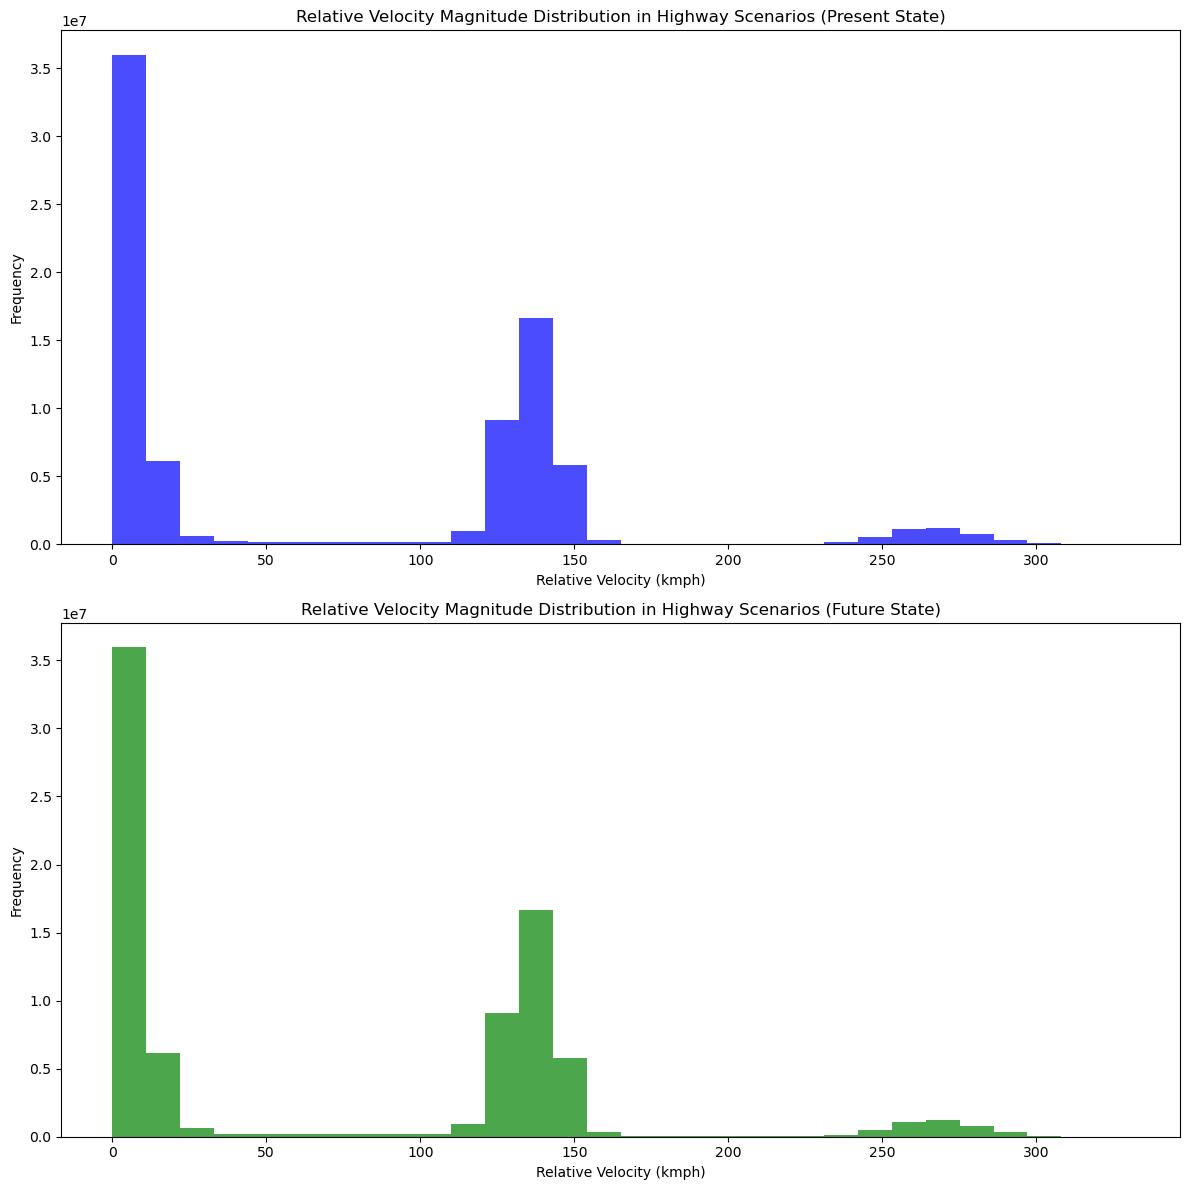

In [8]:
v_rel_combined_highway_previous_state = v_rel_mag_123_previous_state + v_rel_mag_245_previous_state # Combine the relative velocities for the highway scenarios
v_rel_combined_highway_new_state = v_rel_mag_123_new_state + v_rel_mag_245_new_state # Combine the relative velocities for the highway scenarios

# Plot the combined distribution of relative velocities for highway and urban scenarios

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.hist(v_rel_combined_highway_previous_state, bins=30, color='blue', alpha=0.7)
plt.title('Relative Velocity Magnitude Distribution in Highway Scenarios (Present State)')
plt.xlabel('Relative Velocity (kmph)')
plt.ylabel('Frequency')

plt.subplot(2, 1, 2)
plt.hist(v_rel_combined_highway_new_state, bins=30, color='green', alpha=0.7)
plt.title('Relative Velocity Magnitude Distribution in Highway Scenarios (Future State)')
plt.xlabel('Relative Velocity (kmph)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('C:/Users/Vaideeswaran/Documents/ACS Project/Learning Dataset/highway_combined_relative_velocity_distribution.pdf') # Save the plot as an image file
plt.show() # Display the plot

# **Relative Velocity Stats - Urban**

In [6]:
v_rel_mag_100_previous_state, v_rel_mag_100_new_state = [], []
v_rel_mag_200_previous_state, v_rel_mag_200_new_state = [], []
v_rel_mag_300_previous_state, v_rel_mag_300_new_state = [], []

for i in range(len(info_vector_100)):
    v_rel_mag_100_previous_state.append(info_vector_100[i][2]) # Append the relative velocity magnitude from the previous state for 100 vehicles
    v_rel_mag_100_new_state.append(new_state_100[i][2]) # Append the relative velocity magnitude from the new state for 100 vehicles

for i in range(len(info_vector_200)):
    v_rel_mag_200_previous_state.append(info_vector_200[i][2]) # Append the relative velocity magnitude from the previous state for 200 vehicles
    v_rel_mag_200_new_state.append(new_state_200[i][2]) # Append the relative velocity magnitude from the new state for 200 vehicles

for i in range(len(info_vector_300)):
    v_rel_mag_300_previous_state.append(info_vector_300[i][2]) # Append the relative velocity magnitude from the previous state for 300 vehicles
    v_rel_mag_300_new_state.append(new_state_300[i][2]) # Append the relative velocity magnitude from the new state for 300 vehicles


# # Plot the distribution of relative velocities for each traffic scenario

# plt.figure(figsize=(20, 20))
# plt.subplot(3, 2, 1)
# plt.hist(v_rel_mag_100_previous_state, bins=50, color='blue', alpha=0.7)
# plt.title('Relative Velocity Distribution - 100 Vehicles (previous state)')
# plt.xlabel('Relative Velocity (kmph)')
# plt.ylabel('Frequency')

# plt.subplot(3, 2, 2)
# plt.hist(v_rel_mag_100_new_state, bins=50, color='blue', alpha=0.7)
# plt.title('Relative Velocity Distribution - 100 Vehicles (new state)')
# plt.xlabel('Relative Velocity (kmph)')
# plt.ylabel('Frequency')

# plt.subplot(3, 2, 3)
# plt.hist(v_rel_mag_200_previous_state, bins=50, color='orange', alpha=0.7)
# plt.title('Relative Velocity Distribution - 200 Vehicles (previous state)')
# plt.xlabel('Relative Velocity (kmph)')
# plt.ylabel('Frequency')

# plt.subplot(3, 2, 4)
# plt.hist(v_rel_mag_200_new_state, bins=50, color='orange', alpha=0.7)
# plt.title('Relative Velocity Distribution - 200 Vehicles (new state)')
# plt.xlabel('Relative Velocity (kmph)')
# plt.ylabel('Frequency')

# plt.subplot(3, 2, 5)
# plt.hist(v_rel_mag_300_new_state, bins=50, color='green', alpha=0.7)
# plt.title('Relative Velocity Distribution - 300 Vehicles (new state)')
# plt.xlabel('Relative Velocity (kmph)')
# plt.ylabel('Frequency')

# plt.subplot(3, 2, 6)
# plt.hist(v_rel_mag_300_new_state, bins=50, color='green', alpha=0.7)
# plt.title('Relative Velocity Distribution - 300 Vehicles (new state)')
# plt.xlabel('Relative Velocity (kmph)')
# plt.ylabel('Frequency')

# plt.tight_layout()
# plt.savefig('C:/Users/Vaideeswaran/Documents/ACS Project/Learning Dataset/urban_relative_velocity_distribution.svg') # Save the plot as an image file
# plt.show() # Display the plot

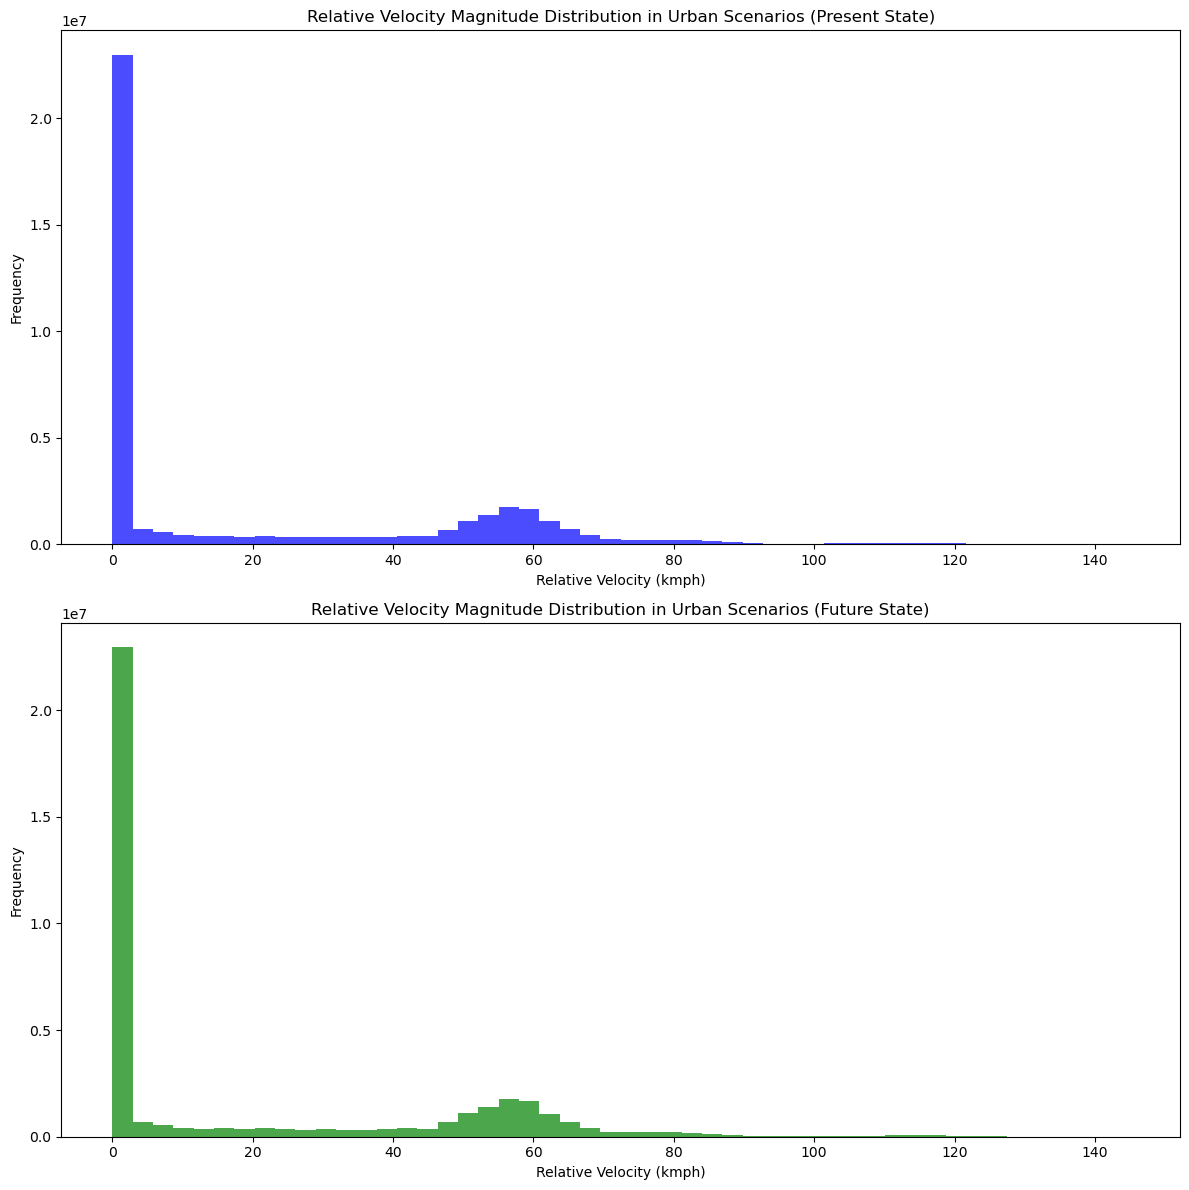

In [7]:
v_rel_combined_urban_previous_state = v_rel_mag_100_previous_state + v_rel_mag_200_previous_state + v_rel_mag_300_previous_state # Combine the relative velocities for the highway scenarios
v_rel_combined_urban_new_state = v_rel_mag_100_new_state + v_rel_mag_200_new_state + v_rel_mag_300_new_state # Combine the relative velocities for the highway scenarios

# Plot the combined distribution of relative velocities for highway and urban scenarios

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.hist(v_rel_combined_urban_previous_state, bins=50, color='blue', alpha=0.7)
plt.title('Relative Velocity Magnitude Distribution in Urban Scenarios (Present State)')
plt.xlabel('Relative Velocity (kmph)')
plt.ylabel('Frequency')

plt.subplot(2, 1, 2)
plt.hist(v_rel_combined_urban_new_state, bins=50, color='green', alpha=0.7)
plt.title('Relative Velocity Magnitude Distribution in Urban Scenarios (Future State)')
plt.xlabel('Relative Velocity (kmph)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('C:/Users/Vaideeswaran/Documents/ACS Project/Learning Dataset/urban_combined_relative_velocity_distribution.svg') # Save the plot as an image file
plt.show() # Display the plot